In [40]:
# Render our plots inline
%matplotlib inline
%pylab inline  
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

# General Plotting Parameters
mpl.rcParams['figure.figsize'] = (8,5)
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['font.weight'] = 'bold'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['font.size'] = 14.
mpl.rcParams['legend.fontsize'] = 12.
mpl.rcParams['axes.labelsize'] = 12.
mpl.rcParams['xtick.labelsize'] = 10.
mpl.rcParams['ytick.labelsize'] = 10.
mpl.rcParams['xtick.minor.pad'] = 4
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.direction'] = 'out'

#Git says this is patched, but it doesn't work from Pip --upgrade 26-mar-2015
#mpl.rcParams['xtick.minor.visible'] = True  

# These are the "Tableau 20" colors as RGB.  
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14),
             (255, 187, 120), (44, 160, 44), (152, 223, 138),
              (148, 103, 189),
             (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127),
             (199, 199, 199), (188, 189, 34), (219, 219, 141),
             (23, 190, 207), (158, 218, 229),(214, 39, 40), (255, 152, 150)]  
    
# Scale the RGB values to the [0, 1] range,
# which is the format matplotlib accepts.  
for i in range(len(tableau20)): 
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)  

ps = 1


Populating the interactive namespace from numpy and matplotlib


In [41]:
import hist_bench
reload(hist_bench)
import gen_fns
reload(gen_fns)
from gen_fns import get_data
from gen_fns import ls_fit
from hist_bench import calc_pursuit
from hist_bench import get_pes
from hist_bench import calc_weights

bin_edges = [0,1,2,3,4,5,6,7,8,9,10]

In [42]:
path = "/Users/mbmcgarry/git/historical_prolif/"
file = "historical_factors.csv"

factor_weights = calc_weights(path+file)

countries, col_names, all_vals = get_data(path+file, n_header=1, col_list=range(2,11))
status = all_vals[:,0]
raw_data = np.delete(all_vals, 0, 1)

for i in range(len(factor_weights)):
    print col_names[i+3], "   ", factor_weights[i]

Auth     0.120515075204
Mil_Iso     0.0751684084996
Reactor     0.176589325711
En_Repr     0.102212269973
Sci_Net     0.0494756908663
Mil_Sp     0.211042298267
Conflict     0.26499693148
U_Res     0.0


In [43]:
all_pe_vals = calc_pursuit(raw_data, factor_weights)
pursue_states, pursue_pes = get_pes(countries, all_pe_vals, "Pursue")
prolif_states, prolif_pes = get_pes(countries, all_pe_vals, "Prolif")

pursue_hist, edges_pur = np.histogram(pursue_pes,bins=bin_edges)
prolif_hist, edges_pro = np.histogram(prolif_pes,bins=bin_edges)
all_hist, edges_a = np.histogram(all_pe_vals, bins=bin_edges)


In [44]:

frac_pursue=np.nan_to_num(pursue_hist.astype(float)/all_hist.astype(float))
#frac_pursue=np.nan_to_num(pursue_hist.astype(float)/190)
frac_prolif=np.nan_to_num(prolif_hist.astype(float)/all_hist.astype(float))
prolif_pursue=np.nan_to_num(prolif_hist.astype(float)/pursue_hist.astype(float))

denom_pursue = np.full(len(pursue_hist),pursue_hist.sum()) 
frac_pursue_weight = pursue_hist/denom_pursue

denom_succ = np.full(len(prolif_pursue),prolif_pursue.sum()) 
frac_succ_weight = prolif_pursue/denom_succ

In [45]:
barwidth=0.8
index = np.delete(bin_edges,-1) + (1-barwidth)
xvals = np.arange(1,11)
int_pursue, m_pursue = ls_fit(xvals, frac_pursue, frac_pursue_weight)
line_vals = m_pursue*xvals + int_pursue

pow_yoff = 0.1
pow_yexp = 1.5
pow_norm = 0.04
pow_vals = 0.04*pow(xvals, pow_yexp)-pow_yoff
resid_pow = np.sum(pow((pow_vals - frac_pursue),2))
resid_lin = np.sum(pow((line_vals - frac_pursue),2))


weights  [ 0.    0.    0.    0.03  0.1   0.17  0.38  0.17  0.14  0.  ]


In [46]:
str_resid_lin = str(round(resid_lin,2))
str_resid_pow = str(round(resid_pow,2))

line_spec_str = "y = "+str(round(m_pursue,3))+ "x - " + str(round(abs(int_pursue),3)) +", rms="+str_resid_lin
pow_spec_str = "y = " + str(pow_norm) + "x^["+str(pow_yexp) + "] - "+str(pow_yoff)+", rms="+str_resid_pow
spec_str = line_spec_str + "\n" + pow_spec_str


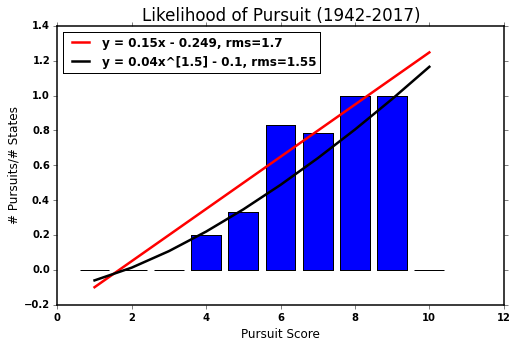

Line Residuals:  1.7049178765  PowerLaw Residuals:  1.55173796864


In [47]:
plt.bar(index+(barwidth/2), frac_pursue, barwidth) #, label=spec_str)
plt.plot(xvals, line_vals, color = 'red',label=line_spec_str)
plt.plot(xvals, pow_vals, color='black',label=pow_spec_str)
plt.title("Likelihood of Pursuit (1942-2017)")
plt.xlabel("Pursuit Score")
plt.ylabel("# Pursuits/# States")
plt.legend(loc='best')

if (ps == 1):
    savefig(path + 'pe_likely.png')

plt.show()


#plt.plot(xvals, pow(xvals/10,4), color='green')
print "Line Residuals: ", resid_lin, " PowerLaw Residuals: ", resid_pow

In [48]:
i=3
print xvals[i]
print pow_vals[i]


4
0.22


In [49]:
time_frac = 1./70
for i in range(len(frac_pursue)):
    cur_val = pow_vals[i]
    if (cur_val >= 1) or (xvals[i] == 10):
        cur_val = 0.999999999
    elif (cur_val < 0):
        cur_val = 0
    likelihood = (1.0 - math.pow((1.0-cur_val), time_frac))
    print "score: ",xvals[i], " frac: ", frac_pursue[i], "fit_val", pow_vals[i],"likely: ", likelihood

score:  1  frac:  0.0 fit_val -0.06 likely:  0.0
score:  2  frac:  0.0 fit_val 0.0131370849898 likely:  0.000188898438758
score:  3  frac:  0.0 fit_val 0.107846096908 likely:  0.00162890937306
score:  4  frac:  0.2 fit_val 0.22 likely:  0.00354315614585
score:  5  frac:  0.333333333333 fit_val 0.3472135955 likely:  0.00607440861146
score:  6  frac:  0.833333333333 fit_val 0.487877538268 likely:  0.00951432819238
score:  7  frac:  0.785714285714 fit_val 0.640810367098 likely:  0.0145207535294
score:  8  frac:  1.0 fit_val 0.805096679919 likely:  0.0230899880522
score:  9  frac:  1.0 fit_val 0.98 likely:  0.0543531071048
score:  10  frac:  0.0 fit_val 1.16491106407 likely:  0.256247272735


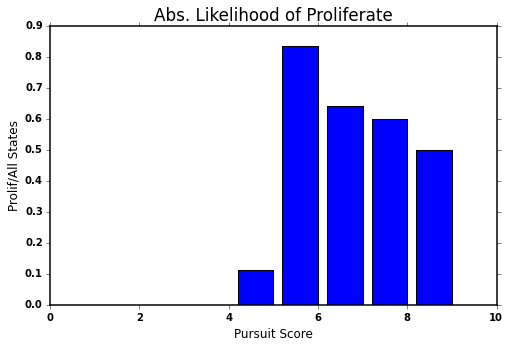

In [50]:
barwidth=0.8
plt.bar(index, frac_prolif, barwidth)

plt.title("Abs. Likelihood of Proliferate")
plt.xlabel("Pursuit Score")
plt.ylabel("Prolif/All States")


weights  [ 0.    0.    0.    0.    0.1   0.31  0.25  0.18  0.15  0.  ]


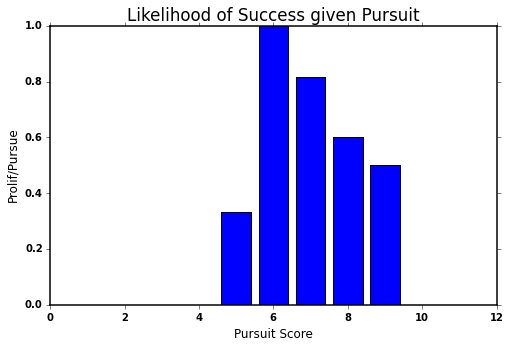

In [51]:
barwidth=0.8

int_succ, m_succ = ls_fit(xvals, prolif_pursue, frac_succ_weight)

plt.bar(index+(barwidth/2), prolif_pursue, barwidth)
#plt.plot(xvals, m_succ*xvals + int_succ, color = 'red')

plt.title("Likelihood of Success given Pursuit")
plt.xlabel("Pursuit Score")
plt.ylabel("Prolif/Pursue")



In [52]:
# Time to acquire. States that never succeeded have negative years in the database, set them all to 30yrs
# (longest time to successfully acquire was 26yrs, all failed attempts were greater than 30yrs from 2015
# except Syria (15yrs) 

from hist_bench import time_to_acquire

# returns time to acquire for all states that have attempted pursuit
acq_times = time_to_acquire()

pursuit_scores = []
corr_acq_times = []


for idx, cur_state in enumerate(countries):
    if (cur_state in acq_times) and (status[idx] == 2):
        cur_time = acq_times[cur_state]
        if (cur_time >= 0):
            corr_acq_times.append(cur_time)
            pursuit_scores.append(all_pe_vals[idx])
            print "State ",cur_state, " Score ", all_pe_vals[idx], " Time ", cur_time
#        To look at the distribution of countries that pursued but never acquired
#        else:
#            corr_acq_times.append(-1*cur_time)
#            pursuit_scores.append(all_pe_vals[idx])
#            print "State ",cur_state, " Score ", all_pe_vals[idx], " Time ", cur_time


int_time, m_time = ls_fit(np.asarray(pursuit_scores), np.asarray(corr_acq_times))


State  US  Score  6.4872  Time  3
State  USSR  Score  8.859  Time  4
State  UK  Score  5.8464  Time  5
State  France  Score  6.7933  Time  6
State  China  Score  6.3277  Time  9
State  Israel  Score  6.1962  Time  9
State  India  Score  6.4368  Time  10
State  Pakist  Score  5.2904  Time  15
State  S-Afric  Score  5.8925  Time  5
State  N-Korea  Score  7.7035  Time  26
weights  [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


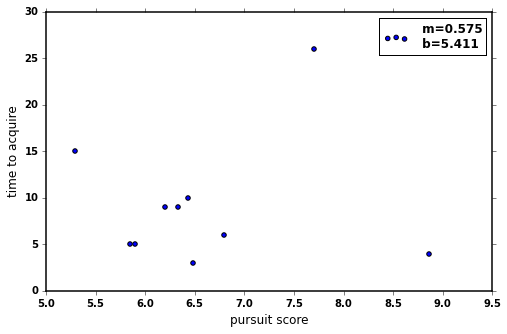

In [53]:
line_spec_str = " m="+str(round(m_time,3))+ "\n b=" + str(round(int_time,3))

plt.scatter(pursuit_scores, corr_acq_times, label=line_spec_str)
plt.xlabel('pursuit score')
plt.ylabel('time to acquire')
#plt.plot(pursuit_scores, m_time*np.asarray(pursuit_scores) + int_time, color = 'red')
plt.legend(loc='best')


In [54]:
# NOT WORKING

# Linear Fit
import scipy as sp
from gen_fns import fit_exp_linear

C0 = 20
# Linear Fit (Note that we have to provide the y-offset ("C") value!!
A, K = fit_exp_linear(np.asarray(pursuit_scores), np.asarray(corr_acq_times), C0)
fit_y= A * np.exp(K * np.asarray(pursuit_scores)) + C0

